# Análisis de compañías del S&P 500

### Importar librerías

In [2]:
import pandas as pd
import numpy as np

# Funciones personalizadas para lectura y carga de información 
from utilities import load_all_tickers, load_ticker 

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística
import pingouin as pg 
from statsmodels.graphics.factorplots import interaction_plot


### Cargar todos los tickers

In [3]:
df = load_all_tickers()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Gap,Intra,Volatilidad,Weekday,Weekday name,Ticker
0,2000-01-03,15.59375,14.68750,14.96875,15.500,7843200.0,15.500,0.000000,0.000000,0.000000,0,Monday,AMD
1,2000-01-04,15.50000,14.59375,15.12500,14.625,6290200.0,14.625,-0.024491,-0.023232,-0.056452,1,Tuesday,AMD
2,2000-01-05,15.06250,14.00000,14.53125,15.000,8204600.0,15.000,-0.006431,-0.008299,0.025641,2,Wednesday,AMD
3,2000-01-06,16.00000,15.25000,15.50000,16.000,11489400.0,16.000,0.032790,0.096287,0.066667,3,Thursday,AMD
4,2000-01-07,16.40625,15.37500,15.40625,16.250,8543400.0,16.250,-0.037815,0.047253,0.015625,4,Friday,AMD


## Análisis del mejor día para invertir usando el rendimiento gap.

**Gap**: Diferencia relativa entre precios Close del día anterior y el actual (escala logarítmica).<br>
Simula una compra al cierre de un día y venta al cierre del día siguiente.<br> 
Las distribuciones para los rendimientos son similares, por lo que se infiere que el día para la inversión no es una variable relevante en el rendimiento gap.

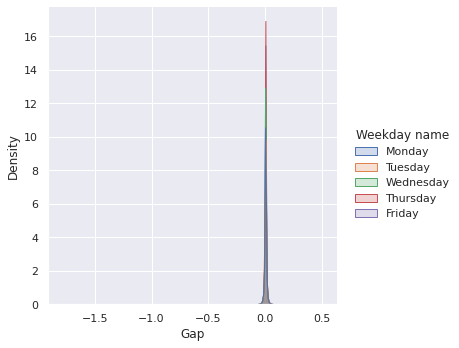

In [4]:
sns.set(rc = {'figure.figsize':(8,8)})


gap_weekday_hist = sns.displot(data = df, x="Gap", hue="Weekday name", kind="kde", fill=True)


#### Visualización con diagrama de cajas. <br>

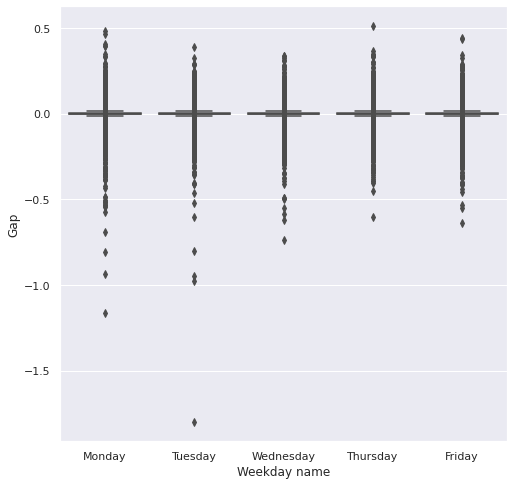

In [5]:
gap_weekday_boxplot = sns.boxplot(data = df, x="Weekday name", y="Gap")

### Verificar condiciones para el test ANOVA para detectar diferencias significativas entre medias
1. Independencia: se toma una muestra aleatoria de cada grupo.
2. Normalidad: se usan test. Las distribuciones de los rendimientos para cada día son similares entre sí pero no normales.

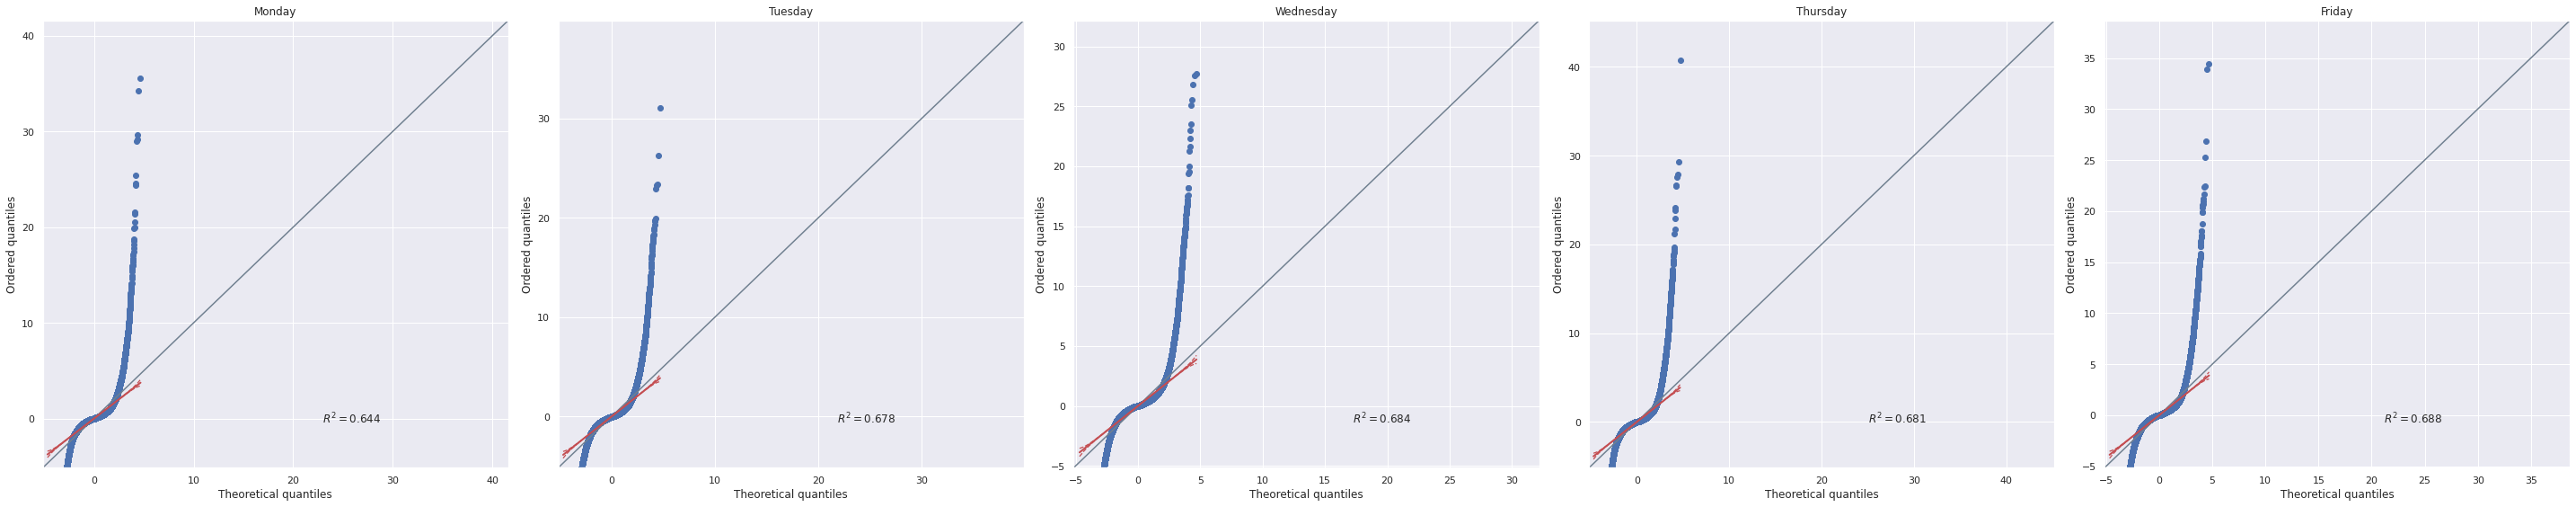

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(40, 8))

for idx, day in enumerate(df['Weekday name'].unique()):
    pg.qqplot(df.loc[df['Weekday name'] == day, 'Gap'], dist = 'norm', ax = axs[idx])    
    axs[idx].set_title(day)    

plt.tight_layout()

In [7]:
sample = df.groupby(['Weekday name']).sample(n = 20, random_state = 42)
sample.groupby('Weekday name')['Gap'].agg('describe')
                

,count,mean,std,min,25%,50%,75%,max
Weekday name,,,,,,,,
Friday,20.0,0.000041,0.008357,-0.022541,-0.002402,0.000656,0.003887,0.014185
Monday,20.0,0.002982,0.008198,-0.006163,-0.001149,0.000984,0.003916,0.031642
Thursday,20.0,0.002763,0.011733,-0.025430,-0.001577,0.002774,0.008966,0.029991
Tuesday,20.0,0.002672,0.007512,-0.009386,-0.002600,0.000914,0.007745,0.017923
Wednesday,20.0,0.000970,0.008447,-0.013380,-0.003563,0.000000,0.003838,0.029372


### Test ANOVA

Conclusiones: no hay suficiente evidencia para decir que algún día tiene mejor rendimiento gap.

In [8]:
pg.anova(data=sample, dv='Gap', between='Weekday name', detailed=True)


,Source,SS,DF,MS,F,p-unc,np2
0,Weekday name,0.000137,4,0.000034,0.4243,0.790753,0.017552
1,Within,0.007647,95,0.000080,NaN,NaN,NaN


### Comparación dos a dos
Se comparan los días de a pares para verficar la diferencia entre medias.<br>
Como era de esperar respecto al resultado previo del test ANOVA, no se observan diferencias significativas (valores P-value).<br> 

In [9]:
pg.pairwise_tukey(data=sample, dv='Gap', between='Weekday name').round(4)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Friday,Monday,0.0000,0.0030,-0.0029,0.0028,-1.0366,0.8377,-0.3213
1,Friday,Thursday,0.0000,0.0028,-0.0027,0.0028,-0.9595,0.8725,-0.2974
2,Friday,Tuesday,0.0000,0.0027,-0.0026,0.0028,-0.9273,0.8856,-0.2874
3,Friday,Wednesday,0.0000,0.0010,-0.0009,0.0028,-0.3276,0.9975,-0.1015
4,Monday,Thursday,0.0030,0.0028,0.0002,0.0028,0.0771,1.0000,0.0239
5,Monday,Tuesday,0.0030,0.0027,0.0003,0.0028,0.1093,1.0000,0.0339
6,Monday,Wednesday,0.0030,0.0010,0.0020,0.0028,0.7091,0.9540,0.2198
7,Thursday,Tuesday,0.0028,0.0027,0.0001,0.0028,0.0322,1.0000,0.0100
8,Thursday,Wednesday,0.0028,0.0010,0.0018,0.0028,0.6319,0.9695,0.1959
9,Tuesday,Wednesday,0.0027,0.0010,0.0017,0.0028,0.5997,0.9748,0.1859


### Resumen de análisis de rendimientos gap.

In [10]:
df.groupby('Weekday name')['Gap'].describe().sort_values(by = 'mean', ascending=False)


,count,mean,std,min,25%,50%,75%,max
Weekday name,,,,,,,,
Tuesday,507797.0,0.000578,0.012413,-1.797111,-0.003260,0.000164,0.004177,0.386317
Friday,496471.0,0.000221,0.012787,-0.640803,-0.003365,0.000237,0.004299,0.440770
Wednesday,508564.0,0.000115,0.012119,-0.734991,-0.003263,0.000000,0.003848,0.336472
Thursday,499712.0,0.000057,0.012510,-0.604080,-0.003454,0.000000,0.003828,0.510056
Monday,466113.0,0.000040,0.013623,-1.161067,-0.003563,0.000000,0.004135,0.484487


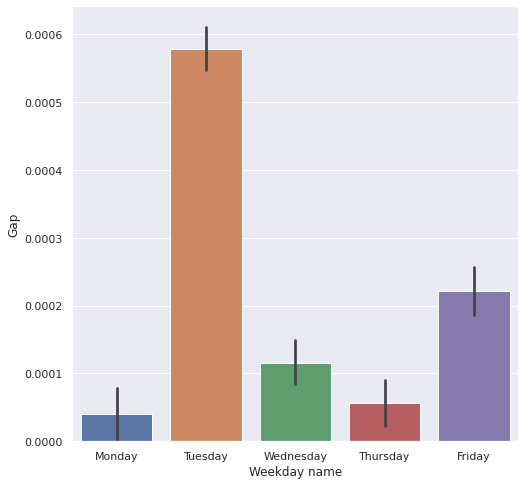

In [11]:
ax = sns.barplot(x = "Weekday name", y="Gap", data = df)

#### Conclusión: 
Los días Martes presentan el mejor valor esperado en el rendimiento gap pero no hay diferencia significativa entre los días.

## Análisis del mejor día para invertir usando el rendimiento intradiario.
**Intra**: Considera la diferencia entre el precio de cierre y el precio de apertura (escala logaritmica).


In [12]:
df.groupby('Weekday name')['Intra'].describe().sort_values(by = 'mean', ascending=False)


,count,mean,std,min,25%,50%,75%,max
Weekday name,,,,,,,,
Friday,496471.0,0.001035,0.030156,-0.649744,-0.011641,0.001392,0.014279,0.767835
Thursday,499712.0,0.000698,0.032009,-0.856553,-0.012415,0.001089,0.014456,0.683559
Wednesday,508564.0,0.000566,0.031326,-0.936080,-0.012365,0.000805,0.013951,0.578078
Tuesday,507797.0,0.000486,0.029977,-1.715465,-0.012227,0.000806,0.013575,0.494364
Monday,466113.0,0.000071,0.031568,-1.198553,-0.012285,0.000608,0.013123,0.815968


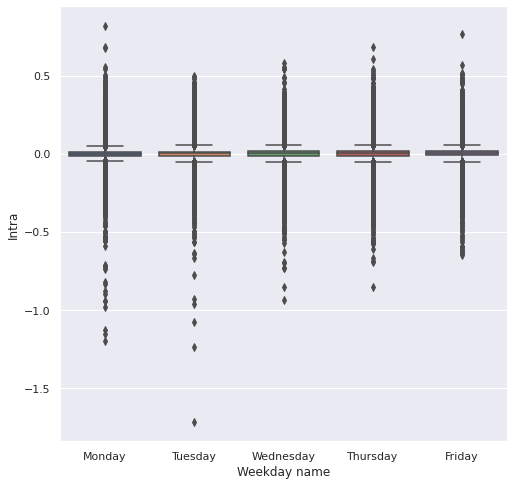

In [13]:
gap_weekday_boxplot = sns.boxplot(data = df, x="Weekday name", y="Intra")

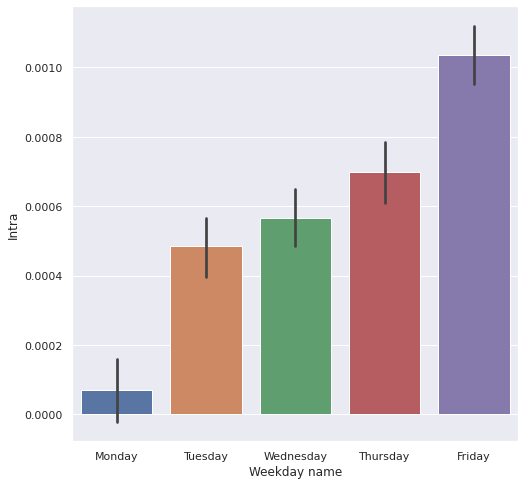

In [14]:
ax = sns.barplot(x = "Weekday name", y="Intra", data = df)


#### Conclusión: 
Los días Viernes presentan el mejor resultado en cuanto a rendimiento intradiario.<br>
De todas maneras, la volatilidad en los rendimientos es un orden de magnitud mayor a la media de rendimientos por lo que hace que ningún día sea significativamente mejor que otro.

### Análisis por sector

Importar Dataframe con empresas y sectores

In [15]:
tickers = pd.read_csv('tickers.csv', 
                usecols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry','Date first added'])

tickers = tickers.rename(columns = {'Symbol':'Ticker'})
tickers['Ticker'] = tickers['Ticker'].apply(lambda x: x.replace('.','-'))

tickers = tickers.drop(tickers.index[(tickers['Ticker']=='CEG')].to_list())

tickers.head()

,Ticker,Security,GICS Sector,GICS Sub-Industry,Date first added
0,MMM,3M,Industrials,Industrial Conglomerates,1976-08-09
1,AOS,A. O. Smith,Industrials,Building Products,2017-07-26
2,ABT,Abbott,Health Care,Health Care Equipment,1964-03-31
3,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31
4,ABMD,Abiomed,Health Care,Health Care Equipment,2018-05-31


**Rendimientos anualizados**: rendimientos gap llevados a términos anuales.<br><br>
**Volatilidad**: desviación estándar de los rendimientos.<br><br>
**Volatilidad anualizada**: volatilidad en términos anuales (multiplicar por raíz cuadrada de los 252 días de trading por año). <br>


In [16]:
rendimientos = df.groupby('Ticker')['Gap'].mean().to_dict()
volatilidad = df.groupby('Ticker')['Volatilidad'].mean().to_dict()

tickers['Rendimientos anualizados'] = (1+tickers['Ticker'].apply(lambda x: rendimientos[x]))**252-1
tickers['Volatilidad anualizada'] = tickers['Ticker'].apply(lambda x: volatilidad[x])*(252**0.5)

tickers.head()


,Ticker,Security,GICS Sector,GICS Sub-Industry,Date first added,Rendimientos anualizados,Volatilidad anualizada
0,MMM,3M,Industrials,Industrial Conglomerates,1976-08-09,0.023207,0.007179
1,AOS,A. O. Smith,Industrials,Building Products,2017-07-26,0.066035,0.013719
2,ABT,Abbott,Health Care,Health Care Equipment,1964-03-31,-0.014353,0.009617
3,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31,0.062948,0.014475
4,ABMD,Abiomed,Health Care,Health Care Equipment,2018-05-31,0.190044,0.018956


### Agrupar resultados por sector.

In [17]:
sectores = tickers.groupby('GICS Sector').mean()
sectores.sort_values(by = 'Rendimientos anualizados', ascending = False).head()

,Rendimientos anualizados,Volatilidad anualizada
GICS Sector,,
Energy,0.147783,0.010940
Consumer Discretionary,0.127182,0.014664
Communication Services,0.102602,0.010573
Information Technology,0.091262,0.015498
Materials,0.087205,0.011145


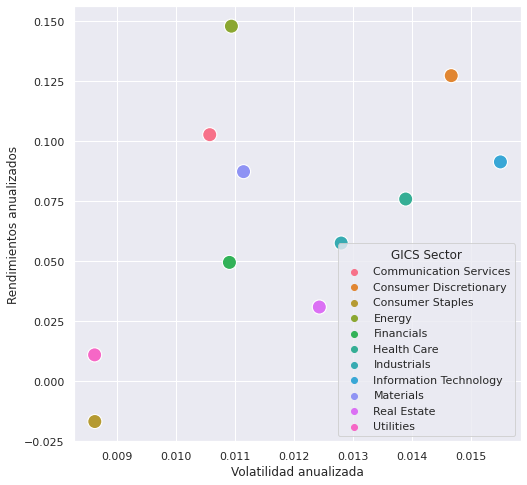

In [18]:
ax = sns.scatterplot(data = sectores, x = "Volatilidad anualizada", y = "Rendimientos anualizados", 
    hue = "GICS Sector", s = 200)

##### Mejor sector para volatilidad anualizada menor a 2% (Riesgo medio-bajo)

In [19]:
mask = (sectores['Volatilidad anualizada'] < 0.02)
sectores[mask].sort_values(by="Rendimientos anualizados", ascending = False).head(1)

,Rendimientos anualizados,Volatilidad anualizada
GICS Sector,,
Energy,0.147783,0.01094


##### Mejor sector para volatilidad anualizada menor a 1% (Riesgo muy bajo)

In [20]:
mask = (sectores['Volatilidad anualizada'] < 0.01)
sectores[mask].sort_values(by="Rendimientos anualizados", ascending = False).head(1)

,Rendimientos anualizados,Volatilidad anualizada
GICS Sector,,
Utilities,0.0109,0.008622


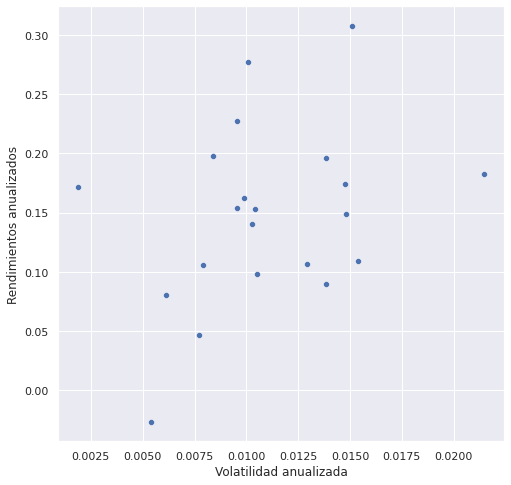

In [30]:
ax = sns.scatterplot(data = tickers[tickers['GICS Sector'] == 'Energy'], 
                    x = "Volatilidad anualizada", 
                    y = "Rendimientos anualizados")

In [32]:
tickers[tickers['GICS Sector'] == 'Energy'].sort_values(by='Rendimientos anualizados',ascending = False).head()

,Ticker,Security,GICS Sector,GICS Sub-Industry,Date first added,Rendimientos anualizados,Volatilidad anualizada,Riesgo
466,VLO,Valero Energy,Energy,Oil & Gas Refining & Marketing,NaN,0.307415,0.015106,Medio
294,MRO,Marathon Oil,Energy,Oil & Gas Exploration & Production,1991-05-01,0.276875,0.010089,Medio
45,APA,APA Corporation,Energy,Oil & Gas Exploration & Production,1997-07-28,0.227217,0.009527,Bajo
223,HAL,Halliburton,Energy,Oil & Gas Equipment & Services,1957-03-04,0.197949,0.008375,Bajo
134,CTRA,Coterra,Energy,Oil & Gas Exploration & Production,2008-06-23,0.196502,0.013848,Medio


### Análisis por empresa

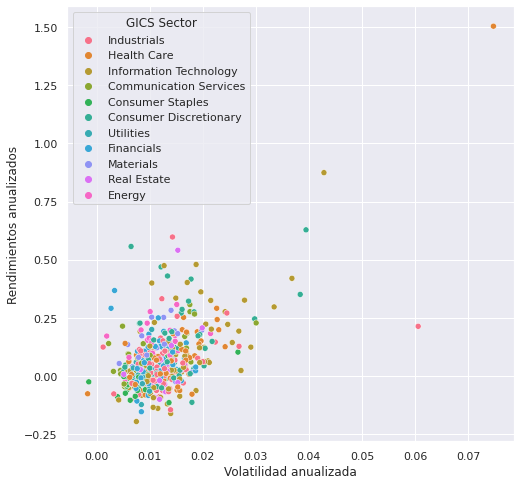

In [22]:
ax = sns.scatterplot(data = tickers, 
                    x = "Volatilidad anualizada", 
                    y = "Rendimientos anualizados", 
                    hue = "GICS Sector")


In [23]:
bins = [0,0.01,0.03,0.50]
labels=['Bajo','Medio','Alto']

tickers['Riesgo'] = pd.cut(tickers['Volatilidad anualizada'], 
                        bins=bins, 
                        labels=labels)

tickers.head()

,Ticker,Security,GICS Sector,GICS Sub-Industry,Date first added,Rendimientos anualizados,Volatilidad anualizada,Riesgo
0,MMM,3M,Industrials,Industrial Conglomerates,1976-08-09,0.023207,0.007179,Bajo
1,AOS,A. O. Smith,Industrials,Building Products,2017-07-26,0.066035,0.013719,Medio
2,ABT,Abbott,Health Care,Health Care Equipment,1964-03-31,-0.014353,0.009617,Bajo
3,ABBV,AbbVie,Health Care,Pharmaceuticals,2012-12-31,0.062948,0.014475,Medio
4,ABMD,Abiomed,Health Care,Health Care Equipment,2018-05-31,0.190044,0.018956,Medio


In [24]:
mask = tickers['Riesgo'] == labels[0]
(tickers[['Ticker','Security', 'Rendimientos anualizados','Volatilidad anualizada','Riesgo']][mask]
        .sort_values(by = 'Rendimientos anualizados', ascending = False)
        .head(9))

,Ticker,Security,Rendimientos anualizados,Volatilidad anualizada,Riesgo
203,F,Ford Motor Company,0.556841,0.006490,Bajo
113,C,Citigroup,0.367617,0.003381,Bajo
33,AIG,American International Group,0.291228,0.002719,Bajo
344,NCLH,Norwegian Cruise Line Holdings,0.227376,0.008173,Bajo
45,APA,APA Corporation,0.227217,0.009527,Bajo
217,GM,General Motors,0.226140,0.008056,Bajo
207,FOXA,Fox Corporation (Class A),0.214319,0.004882,Bajo
223,HAL,Halliburton,0.197949,0.008375,Bajo
131,GLW,Corning Inc.,0.191693,0.008194,Bajo


In [25]:
mask = ((tickers['Riesgo'] == labels[1]) | (tickers['Riesgo'] == labels[0]))
(tickers[['Ticker','Security', 'Rendimientos anualizados','Volatilidad anualizada','Riesgo']][mask]
        .sort_values(by = 'Rendimientos anualizados', ascending = False)
        .head(9))

,Ticker,Security,Rendimientos anualizados,Volatilidad anualizada,Riesgo
30,AAL,American Airlines Group,0.597630,0.014294,Medio
203,F,Ford Motor Company,0.556841,0.006490,Bajo
178,EQIX,Equinix,0.540818,0.015304,Medio
28,AMD,AMD,0.479486,0.018746,Medio
313,MU,Micron Technology,0.474522,0.012714,Medio
281,LVS,Las Vegas Sands,0.468916,0.012142,Medio
311,MGM,MGM Resorts,0.430007,0.013360,Medio
73,BKNG,Booking Holdings,0.416736,0.017797,Medio
419,SWKS,Skyworks Solutions,0.402042,0.017070,Medio


In [26]:
(tickers[['Ticker','Security', 'Rendimientos anualizados','Volatilidad anualizada','Riesgo']]
        .sort_values(by = 'Rendimientos anualizados', ascending = False)
        .head(9))

,Ticker,Security,Rendimientos anualizados,Volatilidad anualizada,Riesgo
316,MRNA,Moderna,1.503848,0.074777,Alto
173,ENPH,Enphase,0.874318,0.042839,Alto
443,TSLA,"Tesla, Inc.",0.628382,0.039459,Alto
30,AAL,American Airlines Group,0.597630,0.014294,Medio
203,F,Ford Motor Company,0.556841,0.006490,Bajo
178,EQIX,Equinix,0.540818,0.015304,Medio
28,AMD,AMD,0.479486,0.018746,Medio
313,MU,Micron Technology,0.474522,0.012714,Medio
281,LVS,Las Vegas Sands,0.468916,0.012142,Medio


### Análisis de la volatilidad

Se busca identificar momentos de mayor volatilidad del conjunto de acciones del S&P500 en el periodo evaluado.<br><br>
Se crea un nuevo dataframe (desviaciones) para evaluar la volatilidad.

In [27]:
desviaciones = df.groupby('Date')['Volatilidad'].std().reset_index()
desviaciones['Nivel'] = desviaciones['Volatilidad'].round(3)

desviaciones.head()

,Date,Volatilidad,Nivel
0,2000-01-03,0.000000,0.000
1,2000-01-04,0.031388,0.031
2,2000-01-05,0.034592,0.035
3,2000-01-06,0.038463,0.038
4,2000-01-07,0.038373,0.038


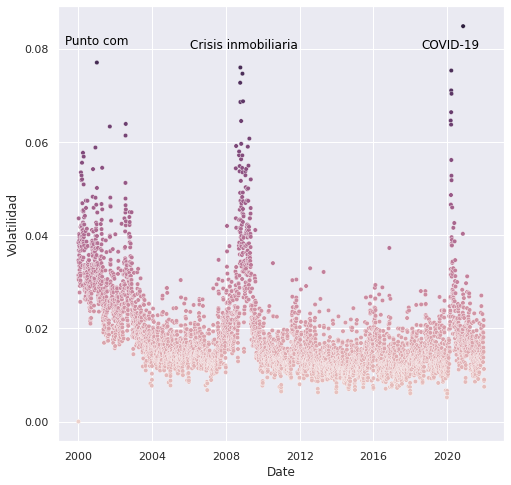

In [28]:
ax = sns.scatterplot(x="Date", y="Volatilidad", hue="Nivel", data=desviaciones, s=20, legend=False )

style = dict(size=12, color='black')
annot1 = ax.text(pd.to_datetime('2001-1-1'),0.081, "Punto com", ha='center', **style)
annot2 = ax.text(pd.to_datetime('2009-1-1'),0.08, "Crisis inmobiliaria", ha='center', **style)
annot3 = ax.text(pd.to_datetime('2020-3-1'),0.08, "COVID-19", ha='center', **style)

